In [47]:
from google.colab import files

uploaded = files.upload()

Saving test_video (1).mp4 to test_video (1).mp4


In [3]:
!pip install opencv-contrib-python torch torchvision kaggle

from google.colab import files
files.upload()

import os
os.makedirs("~/.kaggle", exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d maheshrangala/tusimple-preprocessed-data

import zipfile
with zipfile.ZipFile("tusimple-preprocessed-data.zip", "r") as zip_ref:
    zip_ref.extractall("./dataset")

frames_path = './dataset/tusimple_preprocessed/training/frames'
masks_path = './dataset/tusimple_preprocessed/training/lane-masks'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Saving kaggle (1).json to kaggle (1).json
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/maheshrangala/tusimple-preprocessed-data
License(s): unknown
100% 685M/685M [00:11<00:00, 43.1MB/s]
100% 685M/685M [00:11<00:00, 59.9MB/s]


In [4]:

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Normalize, ColorJitter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import logging
import time
from tqdm import tqdm
from collections import deque
logging.basicConfig(level=logging.INFO)

class LaneDataset(Dataset):
    def __init__(self, frames_path, masks_path, image_transform=None, mask_transform=None):
        self.frames = sorted(os.listdir(frames_path))
        self.masks = sorted(os.listdir(masks_path))
        self.frames_path = frames_path
        self.masks_path = masks_path
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.ego_position = (0.5, 0.9)

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.frames_path, self.frames[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_path, self.masks[idx]), cv2.IMREAD_GRAYSCALE)
        current_lane, other_lanes = self.process_mask(mask)
        mask = np.stack([current_lane, other_lanes], axis=-1)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)
        img = img.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255
        if self.image_transform:
            img = self.image_transform(img)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        return img, mask

    def process_mask(self, mask):
        h, w = mask.shape
        kernel = np.ones((3, 3), np.uint8)
        test_eroded = cv2.erode(mask, kernel, iterations=2)
        test_contours, _ = cv2.findContours(test_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        valid_test_contours = [cnt for cnt in test_contours if cv2.contourArea(cnt) > 20]
        merged_lanes_detected = False
        horizon_y = int(h / 2.6)
        if len(valid_test_contours) < 4:
            for cnt in valid_test_contours:
                x, y, w_box, h_box = cv2.boundingRect(cnt)
                if w_box > w // 3 and y < horizon_y and y + h_box > horizon_y:
                    merged_lanes_detected = True
                    break
        if merged_lanes_detected:
            split_mask = mask.copy()
            split_mask[:horizon_y, :] = 0
            return self._original_process_logic(split_mask)
        else:
            return self._original_process_logic(mask)
    def _original_process_logic(self, mask):
        kernel = np.ones((3, 3), np.uint8)
        eroded_mask = cv2.erode(mask, kernel, iterations=2)
        contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        current_lane = np.zeros_like(mask)
        other_lanes = np.zeros_like(mask)

        if contours:
            h, w = mask.shape
            valid_contours = []

            for cnt in contours:
                if cv2.contourArea(cnt) > 20:
                    M = cv2.moments(cnt)
                    if M["m00"] == 0:
                        continue
                    cx = int(M["m10"] / M["m00"])
                    valid_contours.append((cx, cnt))

            if valid_contours:
                valid_contours.sort(key=lambda x: x[0])
                midpoint = w // 2

                left_contours = [c for c in valid_contours if c[0] < midpoint]
                right_contours = [c for c in valid_contours if c[0] >= midpoint]

                current_cnts = []
                if left_contours:
                    current_cnts.append(left_contours[-1][1])
                if right_contours:
                    current_cnts.append(right_contours[0][1])
                current_refs = [cnt for cnt in current_cnts]
                other_contours = [
                    cnt for cx, cnt in valid_contours
                    if not any(cnt is ref for ref in current_refs)
                ]
                if current_cnts:
                    cv2.drawContours(current_lane, current_cnts, -1, 255, thickness=cv2.FILLED)
                    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
                    current_lane = cv2.morphologyEx(current_lane, cv2.MORPH_CLOSE, kernel_close)

                if other_contours:
                    cv2.drawContours(other_lanes, other_contours, -1, 255, thickness=cv2.FILLED)
                    other_lanes = cv2.morphologyEx(other_lanes, cv2.MORPH_CLOSE, kernel_close)

        return current_lane, other_lanes


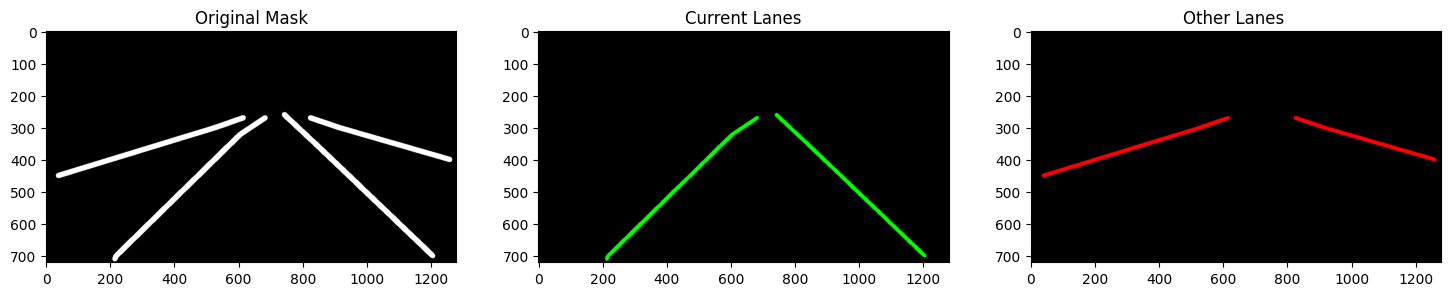

In [5]:

frames_path = "./dataset/tusimple_preprocessed/training/frames"
masks_path = "./dataset/tusimple_preprocessed/training/lane-masks"
dataset = LaneDataset(frames_path, masks_path)


test_mask = cv2.imread(os.path.join(masks_path, dataset.masks[500]), cv2.IMREAD_GRAYSCALE)


current_lane, other_lanes = dataset.process_mask(test_mask)


def visualize_masks(test_mask, current_lane, other_lanes):

    display_current = cv2.cvtColor(current_lane, cv2.COLOR_GRAY2BGR)
    display_current[current_lane > 0] = [0,255,0]

    display_other = cv2.cvtColor(other_lanes, cv2.COLOR_GRAY2BGR)
    display_other[other_lanes > 0] = [255,0,0]

    combined = cv2.addWeighted(display_current, 0.7, display_other, 0.7, 0)

    plt.figure(figsize=(18,6))
    plt.subplot(131), plt.imshow(test_mask, cmap='gray'), plt.title("Original Mask")
    plt.subplot(132), plt.imshow(display_current), plt.title("Current Lanes")
    plt.subplot(133), plt.imshow(display_other), plt.title("Other Lanes ")
    plt.show()



visualize_masks(test_mask, current_lane, other_lanes)

In [6]:


class LaneNet(nn.Module):
    def __init__(self):
        super(LaneNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x = self.dec1(x2)
        x = self.dec2(x)
        x = self.final(x)
        return x


In [7]:

class LaneTracker:
    def __init__(self, buffer_size=15, change_threshold=0.15):
        self.buffer = deque(maxlen=buffer_size)
        self.change_threshold = change_threshold
        self.lane_change = False
        self.alert_counter = 0

    def update(self, current_lane_mask):
        mask = current_lane_mask.squeeze().cpu().numpy()
        h, w = mask.shape
        roi = mask[int(h*0.75):, :]
        y, x = np.where(roi > 0.5)
        if len(x) == 0:
            self.buffer.append(None)
            self.lane_change = False
            return
        centroid_x = np.mean(x) / w
        self.buffer.append(centroid_x)
        if len(self.buffer) == self.buffer.maxlen:
            valid_vals = [v for v in self.buffer if v is not None]
            if len(valid_vals) < 5:
                return
            recent_avg = np.mean(valid_vals[-5:])
            historical_avg = np.mean(valid_vals[:-5])
            if abs(recent_avg - historical_avg) > self.change_threshold:
                self.lane_change = True
                self.alert_counter = 30
            else:
                self.lane_change = False


In [8]:
from torch.utils.data import random_split
def train_model(frames_path, masks_path, epochs=5, batch_size=16, checkpoint_interval=1):
    start_time = time.time()
    image_transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    mask_transform = ToTensor()


    full_dataset = LaneDataset(frames_path, masks_path, image_transform=image_transform, mask_transform=mask_transform)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])


    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device}")

    model = LaneNet().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)

    best_loss = float('inf')
    checkpoint_path = "latest_checkpoint.pth"
    best_iou = 0.0
    start_epoch = 0
    def calculate_iou(pred, target,threshold=0.5):
        pred=(pred>threshold).float()
        intersection = (pred * target).sum((1, 2))
        union = (pred + target - pred * target).sum((1, 2))
        return (intersection / (union + 1e-6)).mean().item()


    if os.path.exists(checkpoint_path):
        logging.info(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['best_loss']
        best_iou = checkpoint.get('best_iou', 0.0)
        logging.info(f"Resuming from epoch {start_epoch}")

    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0.0
        batch_count = 0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        # Training loop
        for images, masks in progress_bar:
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        epoch_loss = running_loss / batch_count

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_iou = 0.0
        val_batch_count = 0
        with torch.no_grad():
            for images, masks in val_dataloader:
                images = images.to(device, dtype=torch.float32)
                masks = masks.to(device, dtype=torch.float32)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
                val_batch_count += 1
                pred_masks = (outputs[:, 0] > 0.5).float()
                val_iou += calculate_iou(pred_masks, masks[:, 0])
        val_loss /= val_batch_count
        logging.info(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, val_iou: {val_iou:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_iou = val_iou
            torch.save(model.state_dict(), "lane_detection_best.pth")
            logging.info(f"New best model saved with validation loss: {best_loss:.4f}, val_iou: {best_iou:.4f}")

        # Save checkpoint
        if (epoch + 1) % checkpoint_interval == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': epoch_loss,
                'val_loss': val_loss,
                'best_loss': best_loss,
                 'best_iou': best_iou
            }, checkpoint_path)
            logging.info(f"Checkpoint saved for epoch {epoch+1}")

        scheduler.step(val_loss)
        print('best_iou:',best_iou)

    torch.save(model.state_dict(), "lane_detection_final.pth")
    logging.info(f"Training completed in {(time.time() - start_time)/60:.2f} minutes")
    return model

In [9]:
def load_model(model_path, device):
    model = LaneNet().to(device)
    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=True)
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            logging.info(f"Loaded model checkpoint from epoch {checkpoint['epoch']}")
        else:
            model.load_state_dict(checkpoint)
            logging.info("Loaded model state dict")
        model.eval()
        for param in model.parameters():
            param.data = param.data.to(dtype=torch.float32)
        return model
    except Exception as e:
        logging.error(f"Error loading model: {e}")
        return None


In [55]:
def process_frame(frame, model, device, tracker):
    orig_frame = frame.copy()
    h, w = orig_frame.shape[:2]
    processed_frame = cv2.resize(frame, (128, 128)).astype(np.float32) / 255.0
    transform = Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    tensor = transform(processed_frame).unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        output = model(tensor)
    current_lane = output[0, 0].cpu().numpy()
    other_lanes = output[0, 1].cpu().numpy()
    tracker.update(output[0, 0:1])
    high_res_h, high_res_w = h*2, w*2
    current_mask = cv2.resize((current_lane > 0.45).astype(np.uint8), (high_res_w, high_res_h), interpolation=cv2.INTER_CUBIC)
    other_mask = cv2.resize((other_lanes > 0.3).astype(np.uint8), (high_res_w, high_res_h), interpolation=cv2.INTER_CUBIC)
    current_mask = cv2.GaussianBlur(current_mask, (5, 5), 0)
    other_mask = cv2.GaussianBlur(other_mask, (5, 5), 0)
    current_mask = (current_mask > 0.5).astype(np.uint8)
    other_mask = (other_mask > 0.5).astype(np.uint8)
    current_color = np.zeros((high_res_h, high_res_w, 3), dtype=np.uint8)
    other_color = np.zeros((high_res_h, high_res_w, 3), dtype=np.uint8)

    def smooth_contour(points):
        points = np.squeeze(points)
        if len(points) < 5: return points
        x = points[:, 0]
        y = points[:, 1]
        z = np.polyfit(y, x, 3)
        p = np.poly1d(z)
        y_new = np.linspace(y.min(), y.max(), 100)
        x_new = p(y_new)
        return np.array([x_new, y_new], dtype=np.int32).T

    contours, _ = cv2.findContours(current_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    for contour in contours:
        smooth_points = smooth_contour(contour)
        cv2.polylines(current_color, [smooth_points], False, (0, 255, 0), 20, lineType=cv2.LINE_AA)

    contours, _ = cv2.findContours(other_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_L1)
    for contour in contours:
        smooth_points = smooth_contour(contour)
        cv2.polylines(other_color, [smooth_points], False, (255, 0, 0), 20, lineType=cv2.LINE_AA)

    current_color = cv2.resize(current_color, (w, h), interpolation=cv2.INTER_CUBIC)
    other_color = cv2.resize(other_color, (w, h), interpolation=cv2.INTER_CUBIC)
    overlay = cv2.addWeighted(orig_frame, 1, current_color, 0.7, 0)
    overlay = cv2.addWeighted(overlay, 1, other_color, 0.7, 0)
    if tracker.lane_change:
        cv2.putText(overlay, "LANE CHANGE DETECTED! RETURN TO LANE", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    return overlay


In [35]:
def test_process_frame(model_path, input_source, output_image_path=None):

    import matplotlib.pyplot as plt

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path, device)
    if model is None:
        print("Failed to load model")
        return False

    tracker = LaneTracker()

    if isinstance(input_source, str):
        if input_source.endswith(('.png', '.jpg', '.jpeg')):
            frame = cv2.imread(input_source)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        else:
            cap = cv2.VideoCapture(input_source)
            success, frame = cap.read()
            cap.release()
            if not success:
                print(f"Couldn't read frame from {input_source}")
                return False
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        frame = input_source.copy()

    if frame is None:
        print("No valid input frame")
        return False
    processed_frame = process_frame(frame, model, device, tracker)
    with torch.no_grad():
        tensor = Compose([
            ToTensor(),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])(cv2.resize(frame, (128, 128))).unsqueeze(0).to(device)
        output = model(tensor)
    fig = plt.figure(figsize=(20, 12))


    ax1 = fig.add_subplot(231)
    ax1.imshow(frame)
    ax1.set_title("Original Frame")
    ax1.axis('off')

    ax2 = fig.add_subplot(232)
    ax2.imshow(output[0,0].cpu().numpy() > 0.35, cmap='gray')
    ax2.set_title("Raw Current Lane Output")
    ax2.axis('off')

    ax3 = fig.add_subplot(233)
    ax3.imshow(output[0,1].cpu().numpy() > 0.5, cmap='gray')
    ax3.set_title("Raw Other Lanes Output")
    ax3.axis('off')


    ax4 = fig.add_subplot(234)
    ax4.imshow(processed_frame)
    ax4.set_title("Final Processed Frame")
    ax4.axis('off')



    return True

In [38]:
def process_video(input_path, output_path, model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info(f"Using device: {device} for video processing")

    model = load_model(model_path, device)
    if model is None:
        logging.error("Failed to load model. Exiting...")
        return

    model.eval()
    tracker = LaneTracker(buffer_size=15, change_threshold=15)

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        logging.error(f"Could not open video: {input_path}")
        return

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    logging.info(f"Processing video with {total_frames} frames...")

    progress_bar = tqdm(total=total_frames, desc="Processing video")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        processed = process_frame(frame, model, device, tracker)
        out.write(processed)

        frame_count += 1
        progress_bar.update(1)

    progress_bar.close()
    cap.release()
    out.release()
    logging.info(f"Video processing complete. Output saved to {output_path}")


In [ ]:

checkpoint_path = "latest_checkpoint.pth"
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)


Found fully trained model: lane_detection_final.pth
Testing model on a single frame...


' print("Processing video...")\n    process_video(input_video, output_video, inference_model_path)\n    print("✅ All tasks completed!")'

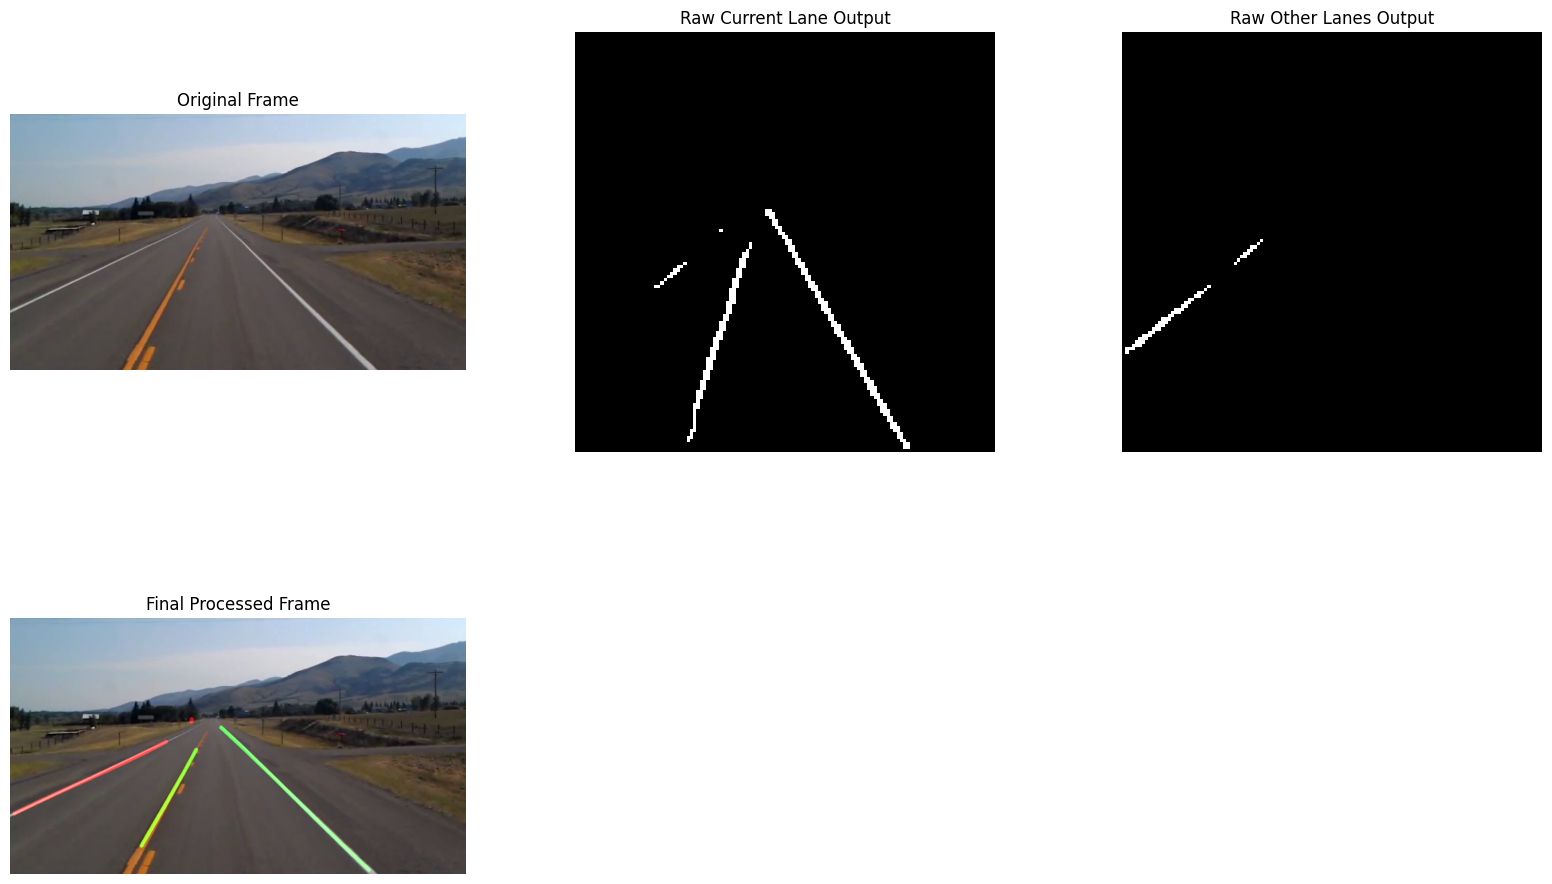

In [56]:

if __name__ == "__main__":
    model_path = "lane_detection_best.pth"
    checkpoint_path = "latest_checkpoint.pth"
    final_model_path = "lane_detection_final.pth"

    training_complete = os.path.exists(final_model_path)
    has_checkpoint = os.path.exists(checkpoint_path)

    if not training_complete:
        print("Final trained model not found.")

        if has_checkpoint:
            print(f"Found checkpoint at {checkpoint_path}. Resuming training...")
        else:
            print("No checkpoint found. Starting training from scratch...")
        model = train_model(frames_path, masks_path, epochs=3, batch_size=16, checkpoint_interval=1)

        if os.path.exists(final_model_path):
            print(f"Model training completed successfully. Final model saved to {final_model_path}")
            inference_model_path = final_model_path
        else:
            print("Training was interrupted. Using best model checkpoint for inference.")
            inference_model_path = model_path
    else:
        print(f"Found fully trained model: {final_model_path}")
        inference_model_path = final_model_path
    input_video = "test_video (1).mp4"
    output_video = "output_video.mp4"
    print("Testing model on a single frame...")


    frame_test_success = test_process_frame(
    model_path="lane_detection_best.pth",
    input_source="test_video (1).mp4"
)
""" print("Processing video...")
    process_video(input_video, output_video, inference_model_path)
    print("✅ All tasks completed!")"""